# Sparse Fourier Transform

## Setup

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import logging
logger = logging.getLogger()
np.random.seed(42)

In [2]:
from tramp.models import DAGModel
from tramp.base import SISOVariable, SIMOVariable, MILeafVariable
from tramp.likelihoods import GaussianLikelihood
from tramp.channels import DFTChannel, Blur1DChannel, GradientChannel
from tramp.priors import GaussBernouilliPrior, GaussianPrior
from tramp.algos import ExpectationPropagation, StateEvolution, TrackEvolution, EarlyStopping, JoinCallback

In [3]:
plt.rc("text", usetex=True)
logger.setLevel(logging.INFO)

In [6]:
def plot_data():
    fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=False, sharex=False)
    axs[0].plot(t, x, label=r"$x(t)$")
    axs[0].plot(t, y, ".", label=r"$y(t)$")
    axs[0].legend()
    axs[0].set(xlabel=r"$t$")
    axs[1].plot(freq, x_fft[0])
    axs[1].set(xlabel=r"$\nu$", ylabel=r"$\mathcal{F}x$", title="real")
    axs[2].plot(freq, x_fft[1], label=r"$\rm{imag}\;\mathcal{F}x$")
    axs[2].set(xlabel=r"$\nu$", ylabel=r"$\mathcal{F}x$", title="imag")
    fig.tight_layout()
    
def plot_prediction(r_pred):
    fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=False, sharex=False)
    axs[0].plot(t, r_pred["x"], label="pred")
    axs[0].plot(t, x, label="true")
    axs[0].legend()
    axs[0].set(xlabel=r"$t$", ylabel=r"$x(t)$")
    x_fft_pred = r_pred["z"]
    axs[1].plot(freq, x_fft[0], label="true")
    axs[1].plot(freq, x_fft_pred[0], label="pred")
    axs[1].legend()
    axs[1].set(xlabel=r"$\nu$", ylabel=r"$\mathcal{F}x$", title="real")
    axs[2].plot(freq, x_fft[1], label="true")
    axs[2].plot(freq, x_fft_pred[1], label="pred")
    axs[2].legend()
    axs[2].set(xlabel=r"$\nu$", ylabel=r"$\mathcal{F}x$", title="imag")
    fig.tight_layout()
    
def run_model(model):
    callback = EarlyStopping(tol=1e-6, min_variance=1e-15)
    ep = ExpectationPropagation(model)
    ep.iterate(max_iter=30, callback=callback)
    r_pred = {x_id: data["r"] for x_id, data in ep.get_variables_data().items()}
    v_pred = {x_id: data["v"] for x_id, data in ep.get_variables_data().items()}
    x_mse = mean_squared_error(x, r_pred["x"])  
    print(f"n_iter={ep.n_iter}")
    print(f"v_pred={v_pred}")
    print(f"x_mse={x_mse}")
    plot_prediction(r_pred)

## Sparse FFT

We use as prior information:

- mean and var of $x$
- FFT is sparse

var_prior = 1.000 rho_fft=0.020 var_fft=18.750


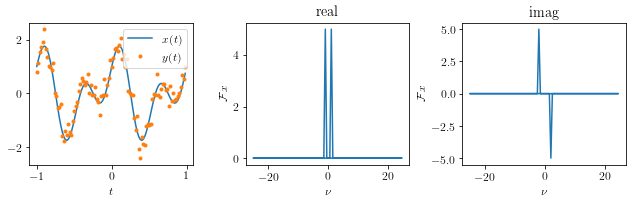

In [10]:
# signal
N = 100
dft = DFTChannel(real=True)
var_noise = 0.1
t = np.linspace(-1, 1, N, endpoint=False)
dt = t[1] - t[0]
x = np.cos(2*np.pi*t) + np.sin(2 * 2*np.pi*t)
x_shape = np.shape(x)
x_fft = dft.sample(x)
freq = np.fft.fftfreq(N, d=dt)
nonzero = np.abs(x_fft)>1e-10
var_prior = x.var()
rho_fft = nonzero.mean()
var_fft = x_fft[nonzero].var()
y = x + np.sqrt(var_noise)*np.random.randn(N)
print(f"var_prior = {var_prior:.3f} rho_fft={rho_fft:.3f} var_fft={var_fft:.3f}")
plot_data()

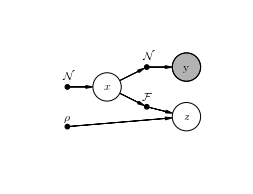

In [11]:
# sparse fft model
fft_shape = (2,) + x_shape
sparse_fft = (
    GaussianPrior(size=N, var=var_prior) @
    SIMOVariable(id="x", n_next=2) @ (
        GaussianLikelihood(y=y, var=var_noise) + (
            DFTChannel(real=True) +
            GaussBernouilliPrior(size=fft_shape, var=var_fft, rho=rho_fft)
        ) @
        MILeafVariable(id="z", n_prev=2)
    )
).to_model_dag()
sparse_fft = DAGModel(sparse_fft)
sparse_fft.daft()

INFO:root:init message dag with ConstantInit(a=0,b=0)
INFO:root:early stopping: all tolerances are below tol=1.00e-06
INFO:root:terminated after n_iter=4 iterations


n_iter=4
v_pred={'x': 0.0020935845252087722, 'z': 0.0020935845252087722}
x_mse=0.012862844646470886


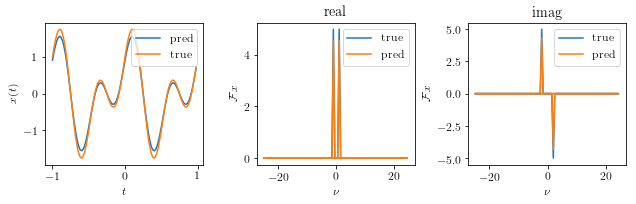

In [12]:
run_model(sparse_fft)